##### Copyright 2018 The TensorFlow Authors.

In [ ]:
import pickle
import numpy as np
import os
import gzip
import torch


def read_data(datasets_dir="./data", frac = 0.1):
    """
    This method reads the states and actions recorded in drive_manually.py 
    and splits it into training/ validation set.
    """
    print("... read data")

    #combines the paths
    data_file = os.path.join(datasets_dir, 'data.pkl.gzip')

    f = gzip.open(data_file,'rb')
    data = pickle.load(f)

    # get images as features and actions as targets
    X = np.array(data["state"]).astype('float32')
    y = np.array(data["action"]).astype('float32')

    # split data into training and validation set
    n_samples = len(data["state"])
    X_train, y_train = X[:int((1-frac) * n_samples)], y[:int((1-frac) * n_samples)]
    X_valid, y_valid = X[int((1-frac) * n_samples):], y[int((1-frac) * n_samples):]
    return X_train, y_train, X_valid, y_valid


def preprocessing(X_train, y_train, X_valid, y_valid, history_length=1):

    # crop, 84 x 84, some pixels never change
    X_train = np.array([img[:-12,6:-6] for img in X_train])
    X_valid = np.array([img[:-12,6:-6] for img in X_valid])
    # grayscale
    X_train = np.array([np.dot(img[...,0:3], [0.299, 0.587, 0.114]) for img in X_train])
    X_valid = np.array([np.dot(img[...,0:3], [0.299, 0.587, 0.114]) for img in X_valid])
    # scaling/normalizing
    X_train = np.array([img/255.0 for img in X_train])
    X_valid = np.array([img/255.0 for img in X_valid])
    
    return X_train, y_train, X_valid, y_valid



In [ ]:
X_train, y_train, X_valid, y_valid = read_data(".")

... read data


In [ ]:
X_train.shape

(18000, 96, 96, 3)

In [ ]:
y_train.shape

(18000, 3)

In [ ]:
X_train, y_train, X_valid, y_valid = preprocessing(X_train, y_train, X_valid, y_valid)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(18000, 84, 84)
(18000, 3)


In [ ]:
print(X_valid.shape)
print(y_train.shape)

(2000, 84, 84)
(18000, 3)


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

model = tf.keras.Sequential([
    #reshaping size to (84, 84, 1) from (84, 84)
    tf.keras.layers.Reshape(target_shape = (84, 84, 1), input_shape=(84, 84)),

    #Convolves kernels to produce a 2d activation map
    tf.keras.layers.Conv2D(4, kernel_size=(11, 11), padding="same", activation=None),

    #takes maximum out of 3x3 going by 1x1 stride
    #padding ='valid' output shape = math.floor((input_shape - pool_size) / strides) + 1
    tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='valid', data_format=None),
    
    tf.keras.layers.Conv2D(8, kernel_size = (5, 5), strides = (1, 1), padding='same', activation=None),
    
    tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='valid', data_format=None),
    
    tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), padding='same', activation=None),
    
    tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), padding='same', activation=None),
    
    tf.keras.layers.Conv2D(8, kernel_size = (3, 3), strides = (1, 1), padding='same', activation=None),

    tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(5, 5), padding='same', data_format=None),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='linear')
    
])

2.7.0


In [ ]:
#TODO. check the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 84, 84, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 84, 84, 4)         488       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 82, 82, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 82, 82, 8)         808       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 80, 80, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 80, 80, 64)        4

In [ ]:
preds = model.predict_on_batch(X_train[:10])
print(preds.shape)
preds

(10, 3)


array([[ 8.8416953e-03,  3.4655910e-05,  2.6830547e-03],
       [-1.2142794e-02, -4.6525337e-04,  2.3752177e-02],
       [-4.6728499e-02, -3.5096522e-02,  3.0322487e-02],
       [-4.6708323e-02, -3.7717719e-02,  6.3959025e-03],
       [-3.9455526e-02, -1.0005561e-02, -1.9140989e-03],
       [-3.5342917e-02,  8.8042459e-03,  3.1076483e-02],
       [-5.4656401e-02,  8.1909541e-03,  4.1281670e-02],
       [-4.5287117e-02,  2.0397022e-02,  5.3111423e-02],
       [-3.5507567e-02,  2.6629854e-02,  6.7972049e-02],
       [-4.3832388e-02,  3.6849476e-02,  7.1537390e-02]], dtype=float32)


### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's [*compile*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) step:

* [*Loss function*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* [*Optimizer*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —This is how the model is updated based on the data it sees and its loss function.
* [*Metrics*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

In [ ]:

history = model.fit(
    x=X_train[:9000],
    y=y_train[:9000],
    batch_size=32,
    epochs=30,
    validation_data=(X_valid, y_valid)
)

Epoch 1/30
282/282 [==============================] - 8s 27ms/step - loss: 0.0072 - mae: 0.0272 - val_loss: 0.0941 - val_mae: 0.1190
Epoch 2/30
282/282 [==============================] - 7s 26ms/step - loss: 0.0086 - mae: 0.0301 - val_loss: 0.0829 - val_mae: 0.1100
Epoch 3/30
282/282 [==============================] - 7s 26ms/step - loss: 0.0056 - mae: 0.0239 - val_loss: 0.0982 - val_mae: 0.1226
Epoch 4/30
282/282 [==============================] - 8s 27ms/step - loss: 0.0059 - mae: 0.0241 - val_loss: 0.0866 - val_mae: 0.1079
Epoch 5/30
282/282 [==============================] - 7s 27ms/step - loss: 0.0052 - mae: 0.0213 - val_loss: 0.0944 - val_mae: 0.1160
Epoch 6/30
282/282 [==============================] - 8s 27ms/step - loss: 0.0062 - mae: 0.0236 - val_loss: 0.0831 - val_mae: 0.1063
Epoch 7/30
282/282 [==============================] - 8s 27ms/step - loss: 0.0055 - mae: 0.0214 - val_loss: 0.0834 - val_mae: 0.1100
Epoch 8/30
282/282 [==============================] - 8s 27ms/step - 

In [ ]:
import pickle
model.save("modeltest30.h5")
with open('/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [ ]:
import pickle
with open("./model_30_history.pickle", "wb") as f:
  pickle.dump(model.history.history, f)

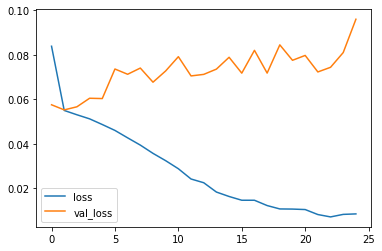

In [ ]:
import matplotlib.pyplot as plt
history.history.keys()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()




In [ ]:
print (tf.__version__)

2.7.0


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic classification: Classify images of clothing

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This guide trains a neural network model to classify images of clothing, like sneakers and shirts. It's okay if you don't understand all the details; this is a fast-paced overview of a complete TensorFlow program with the details explained as you go.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.5.0


## Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [ ]:
train_images.shape

(60000, 28, 28)

Likewise, there are 60,000 labels in the training set:

In [ ]:
len(train_labels)

60000

Each label is an integer between 0 and 9:

In [ ]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

There are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels:

In [ ]:
test_images.shape

(10000, 28, 28)

And the test set contains 10,000 images labels:

In [ ]:
len(test_labels)

10000

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

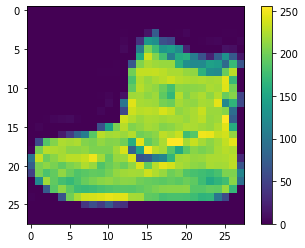

In [ ]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [ ]:
train_images = train_images / 255.0

test_images = test_images / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the *training set* and display the class name below each image.

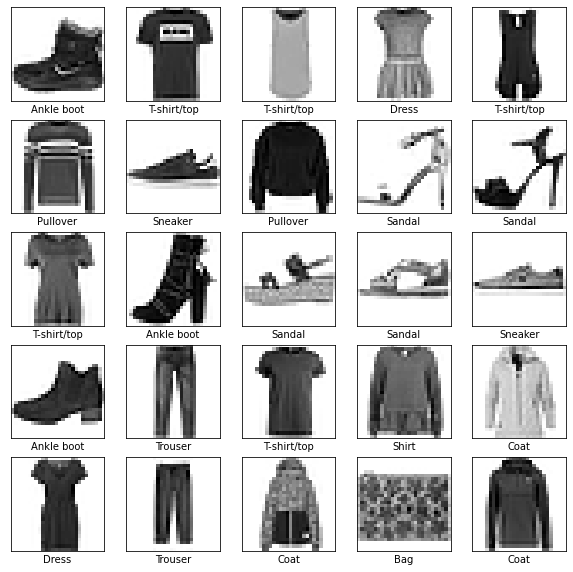

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the [*layer*](https://www.tensorflow.org/api_docs/python/tf/keras/layers). Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2 = tf.keras.Sequential([
    # tf.keras.layers.Flatten(input_shape=(28, 28))
    tf.keras.layers.Reshape(target_shape = (28, 28, 1), input_shape=(28, 28)),
    tf.keras.layers.Conv2D(10, 5, 1, "same"),#, input_shape=(28, 28, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
    
])

In [ ]:
model2.summary(), model2.input_shape

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 10)        260       
_________________________________________________________________
flatten_4 (Flatten)          (None, 7840)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              8029184   
_________________________________________________________________
dense_13 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_15 (Dense)             (None, 10)               

(None, (None, 28, 28))

The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's [*compile*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) step:

* [*Loss function*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* [*Optimizer*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —This is how the model is updated based on the data it sees and its loss function.
* [*Metrics*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_images` array.
4. Verify that the predictions match the labels from the `test_labels` array.


### Feed the model

To start training,  call the [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method—so called because it "fits" the model to the training data:

In [ ]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4939 - accuracy: 0.8257
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3745 - accuracy: 0.8640
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3371 - accuracy: 0.8769
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3130 - accuracy: 0.8854
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2952 - accuracy: 0.8907
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2798 - accuracy: 0.8957
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2675 - accuracy: 0.9009
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2586 - accuracy: 0.9039
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2470 - accuracy: 0.9078
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.237

In [ ]:
model2.fit(train_images, train_labels, epochs=50)

Epoch 1/50
1875/1875 [==============================] - 168s 89ms/step - loss: 0.4218 - accuracy: 0.8457
Epoch 2/50
1875/1875 [==============================] - 168s 90ms/step - loss: 0.3039 - accuracy: 0.8880
Epoch 3/50
1875/1875 [==============================] - 168s 90ms/step - loss: 0.2531 - accuracy: 0.9072
Epoch 4/50
1875/1875 [==============================] - 168s 90ms/step - loss: 0.2077 - accuracy: 0.9216
Epoch 5/50
1875/1875 [==============================] - 166s 89ms/step - loss: 0.1791 - accuracy: 0.9330
Epoch 6/50
1875/1875 [==============================] - 167s 89ms/step - loss: 0.1498 - accuracy: 0.9443
Epoch 7/50
1875/1875 [==============================] - 168s 90ms/step - loss: 0.1208 - accuracy: 0.9549
Epoch 8/50
1875/1875 [==============================] - 168s 90ms/step - loss: 0.1091 - accuracy: 0.9605
Epoch 9/50
1875/1875 [==============================] - 169s 90ms/step - loss: 0.0911 - accuracy: 0.9675
Epoch 10/50
1875/1875 [==============================] 

KeyboardInterrupt: ignored

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.91 (or 91%) on the training data.

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.3728 - accuracy: 0.8738

Test accuracy: 0.8737999796867371


In [ ]:
model2.evaluate(test_images,  test_labels, verbose=2)

313/313 - 6s - loss: 0.5483 - accuracy: 0.8860


[0.5482686161994934, 0.8859999775886536]

It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents *overfitting*. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. For more information, see the following:
*   [Demonstrate overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
*   [Strategies to prevent overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting)

### Make predictions

With the model trained, you can use it to make predictions about some images.
The model's linear outputs, [logits](https://developers.google.com/machine-learning/glossary#logits). Attach a softmax layer to convert the logits to probabilities, which are easier to interpret. 

In [ ]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [ ]:
predictions = probability_model.predict(test_images)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [ ]:
predictions[0]

array([1.6055841e-07, 7.4224921e-10, 2.0953599e-10, 3.4741541e-12,
       1.6947405e-07, 6.1164084e-03, 8.4608665e-08, 1.4092560e-02,
       3.1769932e-07, 9.7979033e-01], dtype=float32)

A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value:

In [ ]:
np.argmax(predictions[0])

9

So, the model is most confident that this image is an ankle boot, or `class_names[9]`. Examining the test label shows that this classification is correct:

In [ ]:
test_labels[0]

9

Graph this to look at the full set of 10 class predictions.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Verify predictions

With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

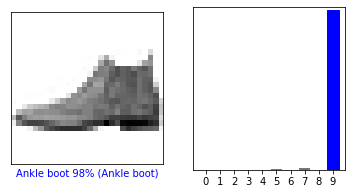

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

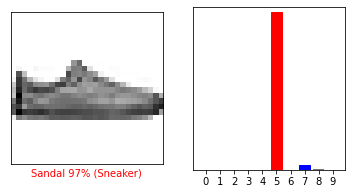

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

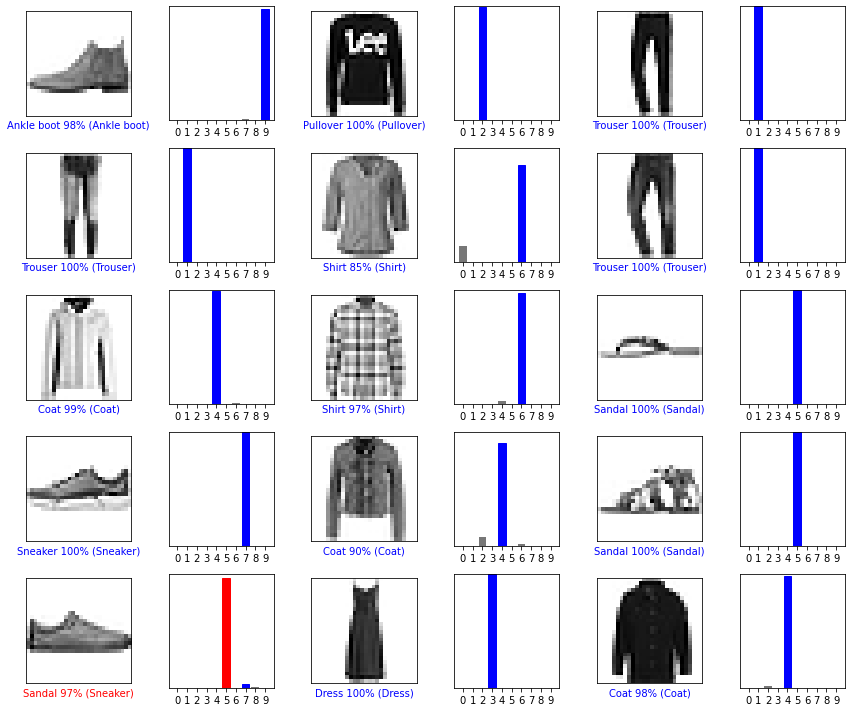

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Use the trained model

Finally, use the trained model to make a prediction about a single image.

In [ ]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [ ]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


Now predict the correct label for this image:

In [ ]:
predictions_single = probability_model.predict(img)

print(predictions_single)

[[1.4035774e-05 3.2978821e-17 9.9755621e-01 2.1488936e-13 2.4000646e-03
  1.8778705e-12 2.9593375e-05 2.6869776e-15 8.4738520e-13 4.6318350e-16]]


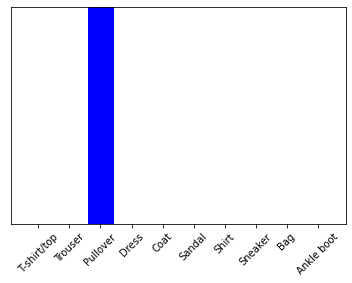

In [ ]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

`tf.keras.Model.predict` returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [ ]:
np.argmax(predictions_single[0])

2

And the model predicts a label as expected.